In [3]:
# format cells using black
%load_ext nb_black

<IPython.core.display.Javascript object>

# requirements
+ sparqlwrapper

In [1]:
import sys
import os
import re
import json
import requests
import pickle
import pandas as pd
from time import sleep
from SPARQLWrapper import SPARQLWrapper, JSON

### sparql utility

In [2]:
endpoint_url = "https://query.wikidata.org/sparql"

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

# categorization

## **1.** wikidata -> wikipedia approach (**SKIP TO 2.**)

In [7]:
# Wikidata Query Service: https://query.wikidata.org/
# SPARQL example queries: https://www.wikidata.org/wiki/Wikidata:SPARQL_query_service/queries/examples

### notes
+ core biographies: https://en.wikipedia.org/wiki/Wikipedia:WikiProject_Biography/Core_biographies
+ get Q-ID for **most common** occupations (high frequency > complete spectrum)
+ property occupation: P106 https://www.wikidata.org/wiki/Property:P106

+ **people can be part of multiple categories**
+ **wikidata title != wikipedia title**


### scientist 
+ Q901
+ https://www.wikidata.org/wiki/Q901

### politician
+ Q82955
+ https://www.wikidata.org/wiki/Q82955

### writer
+ Q36180
+ https://www.wikidata.org/wiki/Q36180

### philosopher
+ Q4964182
+ https://www.wikidata.org/wiki/Q4964182

### theologian
+ Q1234713
+ https://www.wikidata.org/wiki/Q1234713

### SPARQL example query
+ receive **de** articles from **people** categorized under **occupation** **scientist** (Q901) -- replace scientist qid with other category-qid

## load corpus to filter articles

In [9]:
path = os.path.abspath("")
data_df_rel = "data/df/"
data_df_ndb_abs = os.path.join(path, data_df_rel, "df_ndb_wikipedia.pkl")
corpus = pd.read_pickle(data_df_ndb_abs)
wikipedia_titles_df = corpus["wikipedia_title"].tolist()

## get wikipedia titles of people in dataframe, grouped by categories

In [26]:
pattern_uri_qid = re.compile(r"^http://www.wikidata.org/.*/(Q\d+)$")

qids={"Q901":"scientist","Q82955":"politician","Q36180":"writer","Q4964182":"philosopher","Q1234713":"theologian"}
# key:=category, value:=List[<wikipedia titles(:str) of people with this occupation>]
categories = {"scientist":[],"politician":[],"writer":[],"philosopher":[],"theologian":[]}
categories_len = len(categories)
categories_failure = []
request_mediawiki_failure = 0
lang_missing = 0 # no de wikipedia article
sitelink_missing = 0 # wikipedia article not linked
err = 0
articles_total = 0
for i,qid in enumerate(qids):
    query = """select distinct ?item ?itemLabel ?itemDescription ?sitelinks where {
        ?item wdt:P31 wd:Q5;  # Any instance of a human.
              wdt:P106 wd:"""+f"{qid}"+""";  #  Who is related to occupation <param qid>
                 wikibase:sitelinks ?sitelinks.

        SERVICE wikibase:label { bd:serviceParam wikibase:language "de" }
    }
    ORDER BY DESC(?sitelinks)"""
    results=None
    try:
        results = get_results(endpoint_url, query)
    except Exception:
        categories_failure.append(qids[qid])
    if results is None:
        continue
    articles_len = len(results["results"]["bindings"])
    articles_total+=articles_len
    for j,result in enumerate(results["results"]["bindings"]):
        print(f"category: {i+1}/{categories_len} | {qid=} ({qids[qid]}) | {j+1}/{articles_len} | {categories_failure=} {request_mediawiki_failure=} {lang_missing=} {sitelink_missing=} {articles_total} {err=}", end="\r")
        try:
            wikidata_uri = result["item"]["value"]
            if "xml:lang" not in result["itemLabel"]:
                lang_missing+=1
                continue
            if result["itemLabel"]["xml:lang"] != "de":
                lanlang_missingg_error+=1
                continue
            wikidata_title = result["itemLabel"]["value"]
            result_qid = pattern_uri_qid.findall(wikidata_uri)[0]

            response = requests.get(
                url="""https://www.wikidata.org/w/api.php?action=wbgetentities&format=json&props=sitelinks&ids="""+f"{result_qid}"+"""&sitefilter=dewiki""", timeout=10
            )
            status_code = response.status_code
            if status_code != 200:
                request_mediawiki_failure+=1
                continue
            response = response.json()
            # check for empty sitelinks dict
            if not response["entities"][result_qid]["sitelinks"]:
                sitelink_missing+=1
                continue
            wikipedia_title = response["entities"][result_qid]["sitelinks"]["dewiki"]["title"]
            # filter
            if wikipedia_title in wikipedia_titles_df:
                categories[qids[qid]].append(wikipedia_title)
            sleep(0.01)
        except Exception as e:
            err+=1

### store data

In [29]:
cwd = os.getcwd()
output_file_path = os.path.join(cwd, "data/categories/categories.pkl")
with open(output_file_path, "wb") as f:
    pickle.dump(categories, f)

### load data

In [33]:
with open(output_file_path, "rb") as f:
    d = pickle.load(f)
    # check number of matching articles per category
    print([*map(len,d.values())])
    for l in d:
        print(d[l][:5])

[32, 0, 0, 668, 1267]
['Albert Einstein', 'Alexander von Humboldt', 'Johann Amos Comenius', 'Tadeus Reichstein', 'Otto von Guericke']
[]
[]
['Albert Einstein', 'Karl Marx', 'Johann Wolfgang von Goethe', 'Friedrich Nietzsche', 'Martin Luther']
['Johann Wolfgang von Goethe', 'Martin Luther', 'Johannes Kepler', 'Erasmus von Rotterdam', 'Albert Schweitzer']


### problems
+ wikidata query: timeout limit reached... (example: politician,writer)
+ inefficient

## **2.** wikipedia -> wikidata approach

In [3]:
path = os.path.abspath("")
data_df_rel = "data/df/"
data_df_ndb_abs = os.path.join(path, data_df_rel, "df_ndb_wikipedia.pkl")
corpus = pd.read_pickle(data_df_ndb_abs)
wikipedia_titles = corpus["wikipedia_title"].tolist()
wikipedia_titles_len = len(wikipedia_titles)

In [6]:
pattern_uri_qid = re.compile(r"^http://www.wikidata.org/.*/(Q\d+)$")
wikipedia_title_wikidata_qid = {}

# load prev collected data
cwd = os.getcwd()
output_file_path = os.path.join(cwd, "data/categories/wikipedia_title_wikidata_qid_occupations.pkl")
prev_data_state=None
biographies_restored = 0
skipped=0
try:
    with open(output_file_path, "rb") as f:
        prev_data_state = pickle.load(f)
        biographies_restored = len(prev_data_state)
        wikipedia_title_wikidata_qid = prev_data_state
except Exception:
      pass

request_mediawiki_failure=0
request_wikidata_qid_failure=0
request_wikidata_occupations_failure=0
for i,wikipedia_title in enumerate(wikipedia_titles):
    print(f"processing: {i+1}/{wikipedia_titles_len} | stored: {len(wikipedia_title_wikidata_qid)} {skipped=} | {request_mediawiki_failure=} {request_wikidata_qid_failure=} {request_wikidata_occupations_failure=}", end="\r")
    sleep(0.001)
    
    if wikipedia_title in wikipedia_title_wikidata_qid:
        skipped+=1
        continue
    # wikidata-id by title
    # https://en.wikipedia.org/wiki/Wikipedia:Finding_a_Wikidata_ID
    wikipedia_title_query=wikipedia_title.replace(" ","_")
    response = requests.get(
        url="""https://en.wikipedia.org/w/api.php?action=query&prop=pageprops&ppprop=wikibase_item&redirects=1&titles="""+f"{wikipedia_title_query}"+"""&format=json""", timeout=10
    )
    status_code = response.status_code
    if status_code != 200:
        request_mediawiki_failure+=1
        continue
    response = response.json()
    qid=None
    pages_check = list(response["query"]["pages"].values())[0]
    # if qid can't get recieved by query output: try sparql query
    if "-1" in response["query"]["pages"] or "missing" in pages_check or "pageprops" not in pages_check:
        try:
            assert response["query"]["normalized"][0]["from"] == wikipedia_title_query
            wikidata_title = response["query"]["normalized"][0]["to"]
            query = '''SELECT distinct ?item ?itemLabel ?itemDescription WHERE{  
              ?item ?label "'''+f"{wikidata_title}"+'''"@de.  
              ?item wdt:P31 wd:Q5 .
              ?article schema:about ?item .
              ?article schema:inLanguage "de" .
              ?article schema:isPartOf <https://de.wikipedia.org/>. 
              SERVICE wikibase:label { bd:serviceParam wikibase:language "de". }    
            }'''
            results = get_results(endpoint_url, query)
            wikidata_uri = results["results"]["bindings"][0]["item"]["value"]
            qid = pattern_uri_qid.findall(wikidata_uri)[0]
        except Exception as e:
            # results["results"]["bindings"] list empty (no match)
            request_wikidata_qid_failure+=1
            continue
    else:
        qid = list(response["query"]["pages"].values())[0]["pageprops"]["wikibase_item"]
    #get occupations
    occupations=[]
    try:
        query = '''SELECT distinct ?item ?occupationLabel ?occupation WHERE { 
          SERVICE wikibase:label { bd:serviceParam wikibase:language "de". }
          ?item wdt:P106 ?occupation.
          BIND(wd:'''+f"{qid}"+''' AS ?item).
        }
        '''
        results = get_results(endpoint_url, query)
        for result in results["results"]["bindings"]:
            occupations.append(result["occupationLabel"]["value"])
    except Exception:
        request_wikidata_occupations_failure+=1
        continue
    wikipedia_title_wikidata_qid[wikipedia_title]={}
    wikipedia_title_wikidata_qid[wikipedia_title]["qid"]=qid
    wikipedia_title_wikidata_qid[wikipedia_title]["occupations"]=occupations
    # example: {'Hans von Aachen': {'qid': 'Q152835', 'occupations': ['Porträtist', 'Maler', 'Diplomat']}}

### store data

In [85]:
if len(wikipedia_title_wikidata_qid) > biographies_restored:
    with open(output_file_path, "wb") as f:
        pickle.dump(wikipedia_title_wikidata_qid, f)
    print(f"data about {len(wikipedia_title_wikidata_qid)-biographies_restored} new biographies stored.")

### load data
+ reminder: **people can be part of multiple categories**

In [15]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
cwd = os.getcwd()
output_file_path = os.path.join(cwd, "data/categories/wikipedia_title_wikidata_qid_occupations.pkl")
categories = {}
with open(output_file_path, "rb") as f:
    d = pickle.load(f)
    for k,v in d.items():
        for occ in v["occupations"]:
            if occ not in categories:
                categories[occ]=0
            else:
                categories[occ]+=1
print(f'number of categories: {len(categories)}')

number of categories: 1154


In [19]:
# get (top) categories with >=100 associated people --out of those ~17k/~20k biographies
categories_list = sorted([(k,v) for k,v in categories.items()],key=lambda x:x[1],reverse=True)
categories_list = [t for t in categories_list if t[1]>400]

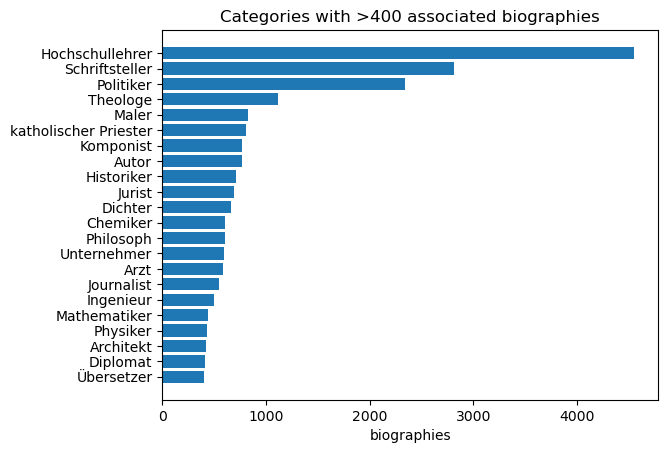

In [18]:
labels=[t[0] for t in categories_list]
values=[t[1] for t in categories_list]
y_pos = np.arange(len(labels))

plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(y_pos, values)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('biographies')
ax.set_title('Categories with >400 associated biographies')

plt.show()